<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch
from torch import distributions
# from .base import BaseEstimator
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
import torch.nn.functional as F
#from arff2pandas import a2p

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Exploration

In [4]:
data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]


In [5]:
counts = [i[0] for i in data_train]

In [6]:
classes = dict((x,counts.count(x)) for x in set(counts))

In [7]:
classes

{1.0: 2919, 2.0: 1767, 3.0: 96, 4.0: 194, 5.0: 24}

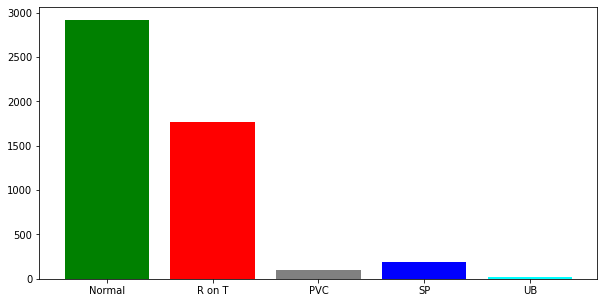

In [8]:


class_names = ['Normal','R on T','PVC','SP','UB']
values = list(classes.values())


fig = plt.figure(figsize = (10, 5))

plt.bar(class_names, values, color =['green', 'red', 'gray', 'blue', 'cyan']
, width = 0.8)

plt.show()

In [9]:
df = pd.DataFrame(data_train)

In [10]:
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns
df.target = [int(i) for i in df.target]

In [11]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

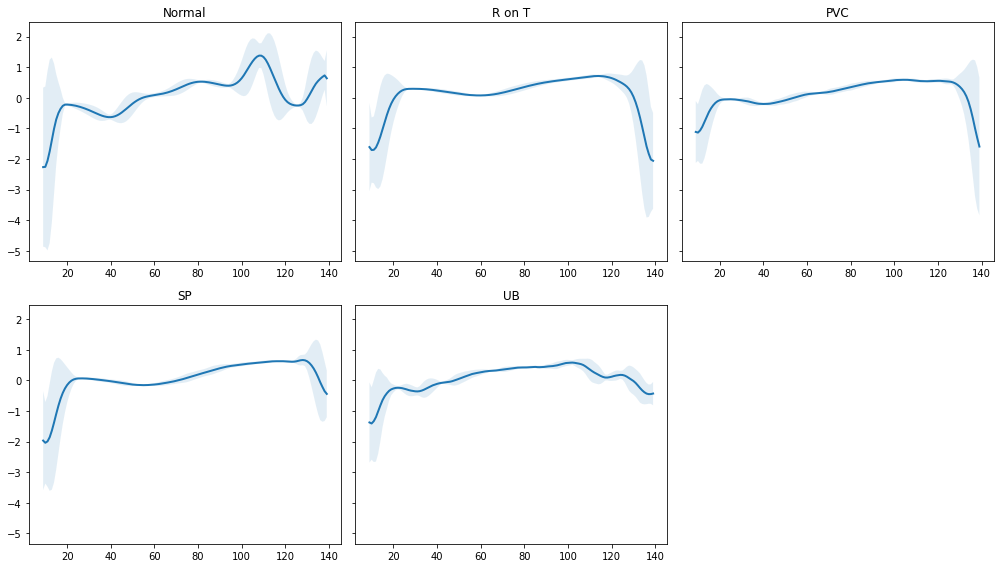

In [12]:
classes = df.target.unique()


fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  #print(data)
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

# Data Pre-processing

In [13]:
#class normal has target equal to 1
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [14]:
# we merge all the other classes into one and use them as train anomalies framework
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [16]:
#split the samples into train, validation, test
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [17]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# VRAE

## Encoder

In [19]:

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

## Decoder


In [20]:

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

##VAE

In [21]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
batch_size = 32
#n_features = ?

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples, seq_len,n_features,embedding_dim=64):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
        self.seq_len = seq_len 
        

        # We encode the data onto the latent space using two linear layers
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc_mu = nn.Linear(128, latent_features)
        self.fc_log_var = nn.Linear(128, latent_features)
        self.fc2 = nn.Linear(latent_features, embedding_dim)

        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x): 
        outputs = {}
        
        x = self.encoder(x)

        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        x = x.unsqueeze(-1)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs

In [39]:
cuda = torch.cuda.is_available()
latent_features = 5
num_samples = 5


net = VariationalAutoencoder(latent_features, num_samples, seq_len, n_features, 32).to(device)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=5, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=32, bias=True)
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [40]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
    #kl = 0 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

In [41]:
from torch.autograd import Variable

#x, _ = next(iter(train_dataset))
#x = Variable(x)
x =train_dataset[0].to(device)
if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss,kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([140, 1])
torch.Size([140, 1])
torch.Size([1, 32])
tensor(0.7123, device='cuda:0', grad_fn=<NegBackward>)
tensor(0.0145, device='cuda:0', grad_fn=<SumBackward0>)


In [42]:
import os

def train_model(model,train_dataset,val_dataset,num_epochs):
  history_elbo = dict(train_elbo=[], val_elbo=[])
  history_kl = dict(train_kl=[], val_kl=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0


  device = torch.device("cuda:0" if cuda else "cpu")
  print("Using device:", device)

  for epoch in range(num_epochs):
      model.train()
      
      # Go through  in the training dataset 
      train_elbo_losses, train_kl_losses = [], []
      for x in train_dataset:
          # This is an alternative way of putting
          # a tensor on the GPU
          x = x.to(device)
          
          outputs = model(x)
          x_hat = outputs['x_hat']
          mu, log_var = outputs['mu'], outputs['log_var']

          elbo, kl = loss_function(x_hat, x, mu, log_var)
          
          optimizer.zero_grad()
          elbo.backward()
          optimizer.step()
          

          train_elbo_losses.append(elbo.item())
          train_kl_losses.append(kl.item())

      # Evaluate, do not propagate gradients
      with torch.no_grad():
          model.eval()
      valid_elbo_losses, valid_kl_losses = [], []   
      for x in val_dataset:
          x = x.to(device)
          
          outputs = model(x)
          x_hat = outputs['x_hat']
          mu, log_var = outputs['mu'], outputs['log_var']
          #z = outputs["z"]
          elbo, kl = loss_function(x_hat, x, mu, log_var)
          
          valid_elbo_losses.append(elbo.item())
          valid_kl_losses.append(kl.item())
      
      train_elbo_loss = np.mean(train_elbo_losses)
      train_kl_loss = np.mean(train_kl_losses)
      valid_elbo_loss = np.mean(valid_elbo_losses)
      valid_kl_loss = np.mean(valid_kl_losses)
      if valid_elbo_loss < best_loss:
        best_loss = valid_elbo_loss
        best_model_wts = copy.deepcopy(model.state_dict())
      print(f'Epoch {epoch}: train elbo loss {train_elbo_loss} train kl loss {train_kl_loss} val elbo loss {valid_elbo_loss} valid kl loss {valid_kl_loss}') 

      # collecting losses
      history_elbo['train_elbo'].append(train_elbo_loss)
      history_kl['train_kl'].append(train_kl_loss)
      history_elbo['val_elbo'].append(valid_elbo_loss)
      history_kl['val_kl'].append(valid_kl_loss)
  model.load_state_dict(best_model_wts)
  return model.eval(),history_elbo,history_kl

In [43]:
model, history_elbo,history_kl = train_model(net,train_dataset,val_dataset,10)

Using device: cuda:0
Epoch 0: train elbo loss -7.6020812347359765 train kl loss 0.0033663215655465608 val elbo loss -9.306703657420423 valid kl loss 4.923313144124002e-05
Epoch 1: train elbo loss -10.462461873489563 train kl loss 0.00017267325048435123 val elbo loss -11.505068131274331 valid kl loss 3.3577757890720824e-05
Epoch 2: train elbo loss -12.321862708244147 train kl loss 0.00022258852480496673 val elbo loss -13.281012418733928 valid kl loss 0.0003899776284605163
Epoch 3: train elbo loss -15.769526405540002 train kl loss 0.0002521924293122912 val elbo loss -18.671119667564234 valid kl loss 4.654858299489721e-05
Epoch 4: train elbo loss -18.563340347652137 train kl loss 0.00047066356087345983 val elbo loss -19.143186477264038 valid kl loss 0.000562813400001656
Epoch 5: train elbo loss -19.511259419625084 train kl loss 0.0004978030980089796 val elbo loss -20.139255173885783 valid kl loss 0.00033669016060161914
Epoch 6: train elbo loss -20.39833615078519 train kl loss 0.0002483753

In [44]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

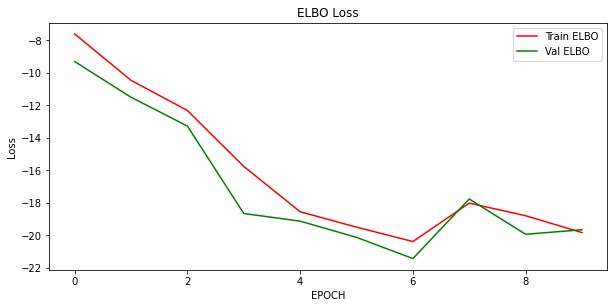

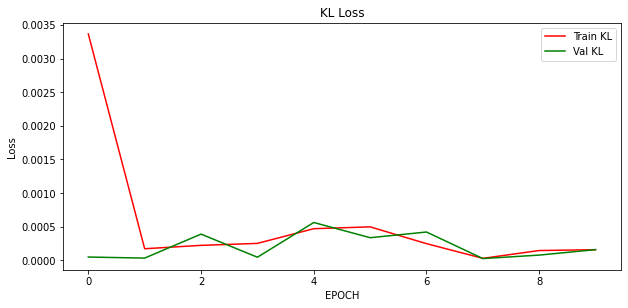

In [45]:

fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['val_elbo']))), history_elbo['val_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')
plt.show();

fig = plt.figure(figsize=(10,10))
plt.subplot(212)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['val_kl']))), history_kl['val_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')

plt.show();

In [46]:
def predict(model, dataset):
  predictions, elbo_losses, kl_losses = [], [],[]
  with torch.no_grad():
    model = model.eval()
    for x in dataset:
        x = x.to(device)
        
        outputs = model(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)

        elbo_losses.append(elbo.item())
        kl_losses.append(kl.item())
        predictions.append(x_hat.cpu().numpy().flatten())
  return predictions, elbo_losses,kl_losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


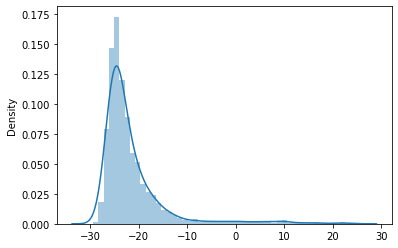

In [47]:
_, elbo_losses, kl_losses = predict(model, train_dataset)

sns.distplot(elbo_losses, bins=50, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


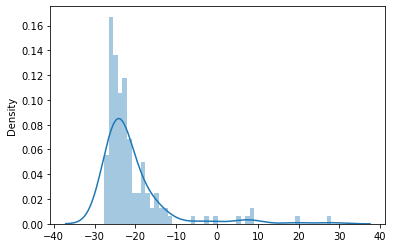

In [48]:
THRESHOLD = 26
_, pred_elbo_losses, pred_kl_losses = predict(model, test_normal_dataset)
sns.distplot(pred_elbo_losses, bins=50, kde=True);

In [49]:
correct = sum([l <= THRESHOLD for l in pred_elbo_losses])
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 144/145


# Anomalies

In [50]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

In [51]:
len(test_anomaly_dataset),len(anomaly_dataset)


(2081, 145)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


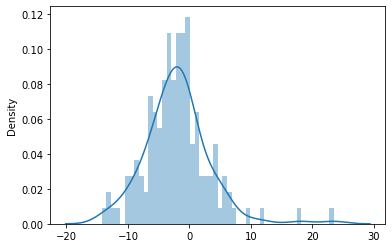

In [52]:
_, pred_elbo_anomaly_losses, pred_kl_anomaly_losses= predict(model, anomaly_dataset)
sns.distplot(pred_elbo_anomaly_losses, bins=50, kde=True);

In [56]:
correct = sum(l > THRESHOLD for l in pred_elbo_anomaly_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 0/145


In [57]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses, kl_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

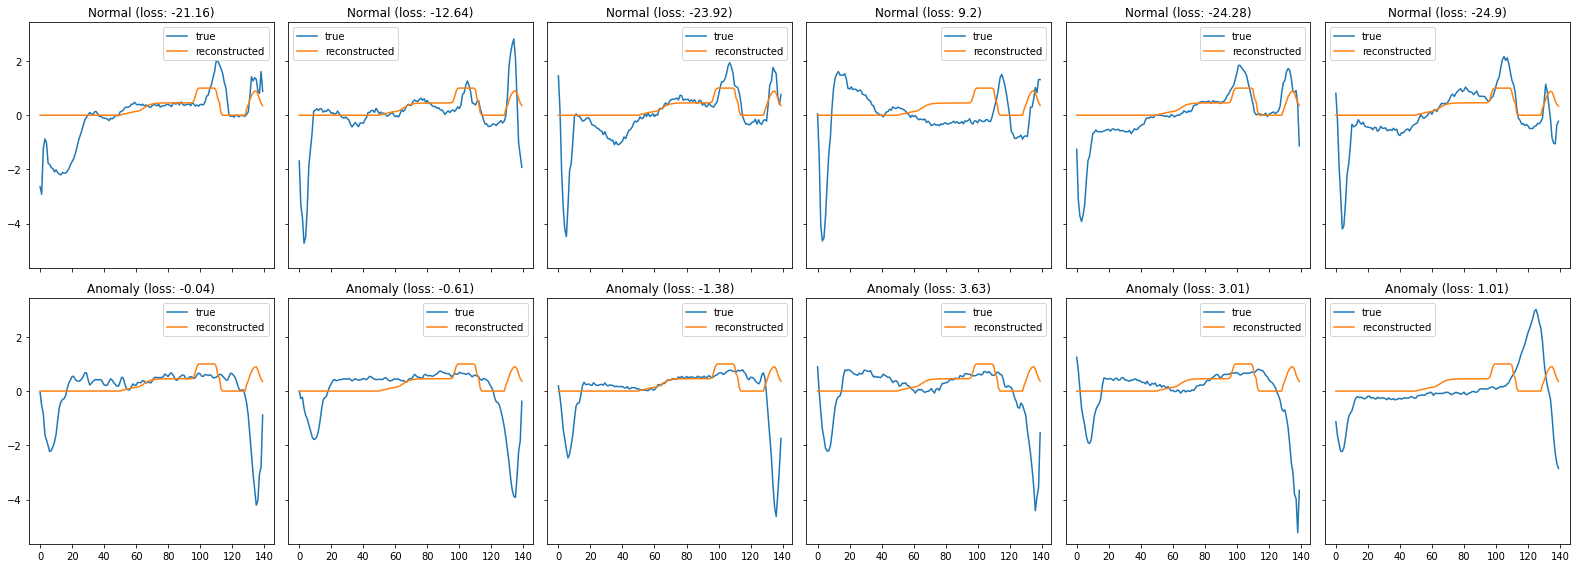

In [58]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();